In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
merged_df = pd.read_csv("cleaned_data/merged_data.csv")

In [ ]:
# Helper Functions

def numeric_summary(s):
    """Compact numeric summary with NA%."""
    s = pd.to_numeric(s, errors='coerce')
    return pd.Series({
        'mean': s.mean(),
        'std': s.std(),
        'min': s.min(),
        '25%': s.quantile(0.25),
        '50% (median)': s.median(),
        '75%': s.quantile(0.75),
        'max': s.max()
    })

def bin_seconds_after(s):
    """Convenient bins for seconds_after_rat_arrival."""
    s = pd.to_numeric(s, errors='coerce')
    bins = [-np.inf, 0, 60, 300, np.inf]
    labels = ['<=0s', '0–60s', '60–300s', '>300s']
    return pd.cut(s, bins=bins, labels=labels, right=True)

In [9]:
key_nums = ['bat_landing_to_food', 'seconds_after_rat_arrival', 'rat_minutes', 'rat_arrival_number', 'hours_after_sunset', 'food_availability']
summary_table = pd.DataFrame({c: numeric_summary(merged_df[c]) for c in key_nums if c in merged_df.columns}).T
display(summary_table)

,mean,std,min,25%,50% (median),75%,max
bat_landing_to_food,11.015246,21.092191,0.010238,1.000000,4.000000,11.750000,148.500000
seconds_after_rat_arrival,282.786976,241.092545,0.000000,89.250000,206.000000,447.250000,949.000000
rat_minutes,5.118422,4.227850,0.000000,0.733333,4.983333,9.554167,11.090000
rat_arrival_number,1.474614,1.301897,0.000000,1.000000,1.000000,2.000000,8.000000
hours_after_sunset,5.532579,2.415383,-0.261667,3.775069,5.627083,7.406250,12.091944
food_availability,2.427342,0.787461,0.000000,2.000000,2.774194,3.000000,4.000000


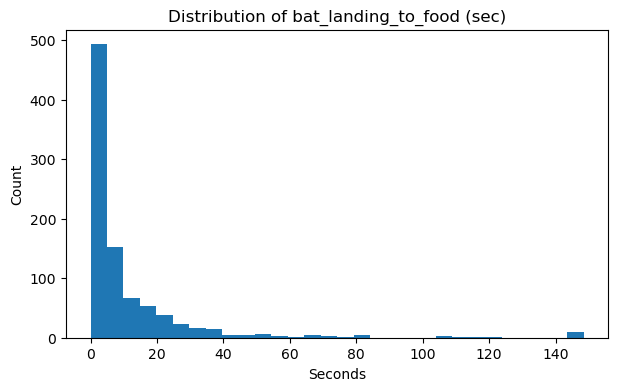

In [10]:
# H1: Latency distributions overall
if 'bat_landing_to_food' in merged_df.columns:
    plt.figure(figsize=(7,4))
    merged_df['bat_landing_to_food'].dropna().plot(kind='hist', bins=30)
    plt.title('Distribution of bat_landing_to_food (sec)')
    plt.xlabel('Seconds')
    plt.ylabel('Count')
    plt.show()

/var/folders/gk/3lnnfsp51hs7txpqd7wtw5840000gn/T/ipykernel_5833/4188537120.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Q1','Q2','Q3','Q4'])


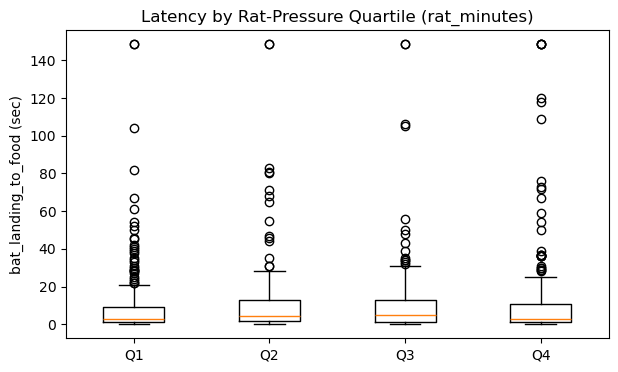

In [11]:
# H1: Latency by rat-pressure quartile
if {'bat_landing_to_food','rat_pressure_q'}.issubset(merged_df.columns):
    data = [merged_df.loc[merged_df['rat_pressure_q']==q, 'bat_landing_to_food'].dropna() for q in ['Q1','Q2','Q3','Q4']]
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=['Q1','Q2','Q3','Q4'])
    plt.title('Latency by Rat-Pressure Quartile (rat_minutes)')
    plt.ylabel('bat_landing_to_food (sec)')
    plt.show()

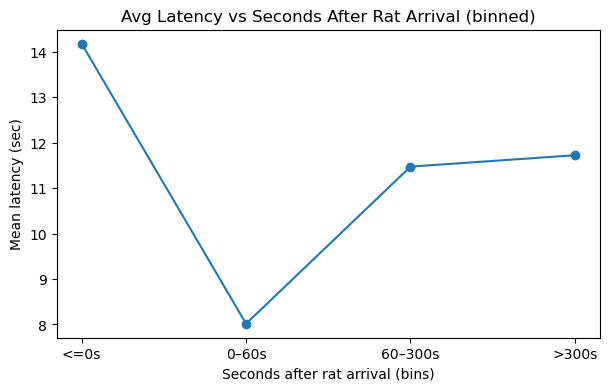

In [12]:
# H1: Binned line — seconds_after_rat_arrival vs avg latency
if {'seconds_after_rat_arrival','bat_landing_to_food'}.issubset(merged_df.columns):
    merged_df['sec_after_bin'] = bin_seconds_after(merged_df['seconds_after_rat_arrival'])
    grp = merged_df.groupby('sec_after_bin', observed=True)['bat_landing_to_food'].mean()
    plt.figure(figsize=(7,4))
    plt.plot(grp.index.astype(str), grp.values, marker='o')
    plt.title('Avg Latency vs Seconds After Rat Arrival (binned)')
    plt.xlabel('Seconds after rat arrival (bins)')
    plt.ylabel('Mean latency (sec)')
    plt.show()

Overall risk-taking rate (risk=1): 0.494


rat_pressure_q
Q1    0.543478
Q2    0.462500
Q3    0.492823
Q4    0.480176
Name: risk, dtype: float64

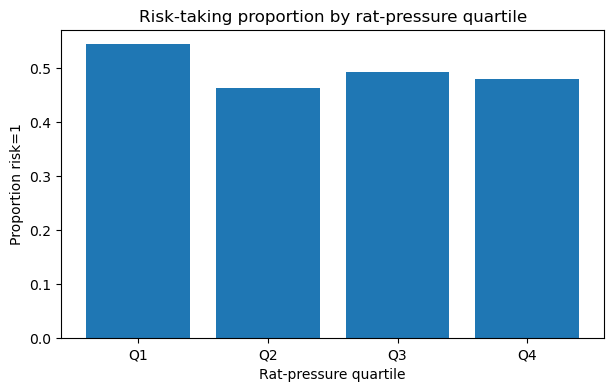

In [13]:
# H2: Risk proportions overall and by quartile
if 'risk' in merged_df.columns:
    risk_rate = merged_df['risk'].mean()
    print(f"Overall risk-taking rate (risk=1): {float(risk_rate):.3f}")
    if 'rat_pressure_q' in merged_df.columns:
        risk_by_q = merged_df.groupby('rat_pressure_q', observed=True)['risk'].mean()
        display(risk_by_q)
        plt.figure(figsize=(7,4))
        plt.bar(risk_by_q.index.astype(str), risk_by_q.values)
        plt.title('Risk-taking proportion by rat-pressure quartile')
        plt.xlabel('Rat-pressure quartile')
        plt.ylabel('Proportion risk=1')
        plt.show()

Overall reward rate: 0.534


rat_pressure_q
Q1    0.504348
Q2    0.541667
Q3    0.545455
Q4    0.546256
Name: reward, dtype: float64

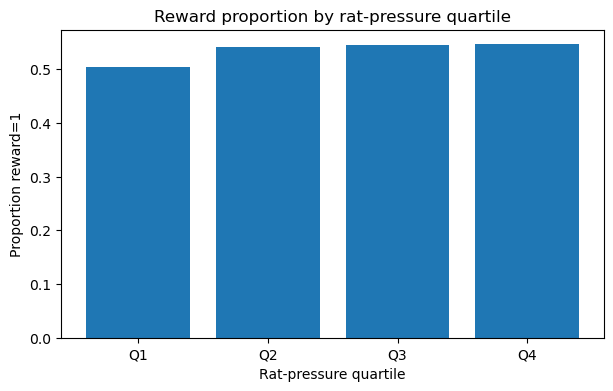

risk
0    0.842795
1    0.218750
Name: reward, dtype: float64

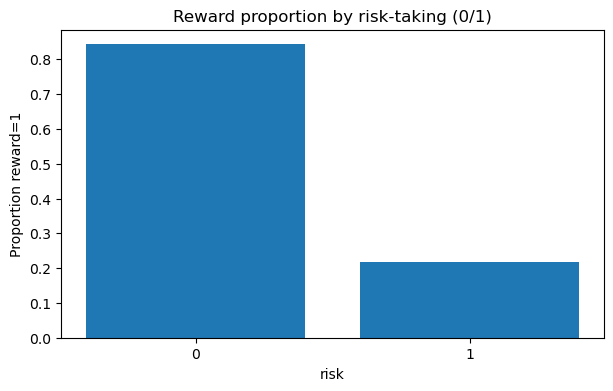

In [14]:
# H3: Reward proportions overall and by quartile, and by risk
if 'reward' in merged_df.columns:
    reward_rate = merged_df['reward'].mean()
    print(f"Overall reward rate: {float(reward_rate):.3f}")

    if 'rat_pressure_q' in merged_df.columns:
        reward_by_q = merged_df.groupby('rat_pressure_q', observed=True)['reward'].mean()
        display(reward_by_q)
        plt.figure(figsize=(7,4))
        plt.bar(reward_by_q.index.astype(str), reward_by_q.values)
        plt.title('Reward proportion by rat-pressure quartile')
        plt.xlabel('Rat-pressure quartile')
        plt.ylabel('Proportion reward=1')
        plt.show()

    if {'reward','risk'}.issubset(merged_df.columns):
        reward_by_risk = merged_df.groupby('risk')['reward'].mean()
        display(reward_by_risk)
        plt.figure(figsize=(7,4))
        plt.bar(reward_by_risk.index.astype(str), reward_by_risk.values)
        plt.title('Reward proportion by risk-taking (0/1)')
        plt.xlabel('risk')
        plt.ylabel('Proportion reward=1')
        plt.show()
